In [2]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [3]:
from old.harmonization import CombatModel
from old.harmonization import SiteWiseStandardScaler

from sklearn.decomposition import PCA
import umap

import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix

In [3]:
def get_scores(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))  # Get predicted class labels

    scores = {"MCC_Overall": matthews_corrcoef(y_true, y_pred),
              "Accuracy": accuracy_score(y_true, y_pred),
              "Precision (Macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
              "Precision (Weighted)": precision_score(y_true, y_pred, average="weighted", zero_division=0),
              "Recall (Macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
              "Recall (Weighted)": recall_score(y_true, y_pred, average="weighted", zero_division=0),
              "F1-Score (Macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
              "F1-Score (Weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
              "AUC (OvR)": roc_auc_score(y_true, y_prob, multi_class="ovr"),
              "AUC (OvO)": roc_auc_score(y_true, y_prob, multi_class="ovo")}

    mcc_per_class = {
        f"MCC_{cls}": matthews_corrcoef((y_true == cls).astype(int), (y_pred == cls).astype(int))
        for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    }
    scores.update(mcc_per_class)

    return scores

def compute_confusion_matrix(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))
    cm = confusion_matrix(y_true, y_pred, labels=label_encoder.inverse_transform(range(len(label_encoder.classes_))))

    return cm

In [4]:
ELM19_info_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_info_filtered_norm.csv'
ELM19_features_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_features_filtered_norm.csv'

In [5]:
df_info = pd.read_csv(ELM19_info_filtered_norm_path)
df_feats = pd.read_csv(ELM19_features_filtered_norm_path)

In [6]:
label_encoder = LabelEncoder()
df_info['institution_id_encoded'] = label_encoder.fit_transform(df_info['institution_id'])
hospital_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

In [7]:
covars = pd.DataFrame()
covars['batch'] = df_info['institution_id_encoded']
covars['gender'] = (df_info['patient_sex'] == 'Male').astype(int)
covars['age'] = df_info['age_dec']

In [8]:
feature_groups = {
    "coh": [col for col in df_feats.columns if col.startswith("coh")],
    "pow": [col for col in df_feats.columns if col.startswith("pow")],
    "cov": [col for col in df_feats.columns if col.startswith("cov")]
}

In [46]:
X = df_feats.loc[:, feature_groups['pow']]
y = df_info['institution_id']

In [10]:
params = {'iterations': 2000,
          'learning_rate': 0.2136106733298358,
          'depth': 5.0,
          'l2_leaf_reg': 1.0050061307458207,
          'eval_metric': 'MultiClass',
          'task_type': "GPU"
}

In [47]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

fold_metrics_list = []
fold_confusion_matrices = {}
all_y_true = []
all_y_pred_proba = []
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    
    logging.info(f"Starting fold {fold_num+1}/5")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    covars_train, covars_test = covars.iloc[train_idx], covars.iloc[test_idx]

    #pca = PCA(n_components=0.95, svd_solver='full', random_state=100)
    #pca.fit(X_train)
    #X_train_pcs = pd.DataFrame(pca.transform(X_train), index=X_train.index)
    #X_test_pcs  = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    combat = CombatModel()
    X_train_harmonized = combat.fit_transform(X_train.to_numpy(), covars_train[['batch']].to_numpy(), covars_train[['gender']].to_numpy(), covars_train[['age']].to_numpy())
    X_test_harmonized = combat.transform(X_test.to_numpy(), covars_test[['batch']].to_numpy(), covars_test[['gender']].to_numpy(), covars_test[['age']].to_numpy())
    
    # scaler = SiteWiseStandardScaler()
    # X_train_harmonized = scaler.fit_transform(X_train, y_train)
    # X_test_harmonized = scaler.transform(X_test, y_test)

    #scaler = LimmaBatchEffectRemover()
    #X_train_harmonized = scaler.fit_transform(X_train, y_train)
    #X_test_harmonized = scaler.transform(X_test, y_test)
    
    logging.info("Initializing the Catboost model...")
    model = CatBoostClassifier(**params)

    logging.info("Training the model...")
    model.fit(X_train_harmonized, y_train, eval_set=(X_test_harmonized, y_test), verbose=False, plot=True)
    logging.info("Model training completed.")

    logging.info("Generating predictions...")
    y_prob = model.predict_proba(X_test_harmonized)
    logging.info("Predictions generated successfully.")

    # 1. Get and store scores for the fold
    scores_fold = get_scores(y_test, y_prob, label_encoder)
    scores_fold['fold'] = fold_num + 1
    fold_metrics_list.append(scores_fold)
    logging.info(f"Results saved.")

    # 2. Get and store confusion matrix for the fold
    cm_fold = compute_confusion_matrix(y_test, y_prob, label_encoder)
    fold_confusion_matrices[f'fold_{fold_num+1}_cm'] = cm_fold

    # 3. Collect out-of-fold predictions
    all_y_true.extend(y_test)
    all_y_pred_proba.extend(y_prob)
    break

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
ALL: RAW 0.865 -> COMBAT 0.959 ||| PCA 0.523 -> COMBAT + PCA 0.692 ||| PATHOLOGY CLASSIFICATION 0.865 -> COMBAT 0.877
COH: RAW 0.850 -> COMBAT 0.928 ||| PCA 0.833 -> COMBAT + PCA 0.642 ||| PATHOLOGY CLASSIFICATION 0.84 -> COMBAT NOT CHECKED
COV: RAW 0.752 -> COMBAT 0.903 ||| PCA 0.530 -> COMBAT + PCA 0.692 ||| PATHOLOGY CLASSIFICATION 0.81 -> COMBAT NOT CHECKED
POW: RAW 0.600 -> COMBAT 0.868 ||| PCA 0.424 -> COMBAT + PCA 0.434 ||| PATHOLOGY CLASSIFICATION 0.77 -> COMBAT NOT CHECKED

SyntaxError: invalid syntax (4115910613.py, line 1)

In [48]:
fold_metrics_list

[{'MCC_Overall': 0.868198885137273,
  'Accuracy': 0.8810688746706812,
  'Precision (Macro)': 0.9100525312218315,
  'Precision (Weighted)': 0.8833718901385297,
  'Recall (Macro)': 0.7055268341206773,
  'Recall (Weighted)': 0.8810688746706812,
  'F1-Score (Macro)': 0.7659379282979383,
  'F1-Score (Weighted)': 0.8736990554654234,
  'AUC (OvR)': 0.9956888018552451,
  'AUC (OvO)': 0.9905019939340678,
  'MCC_AKS': 0.7508006849659271,
  'MCC_ARCHDAM': 0.8768932365558324,
  'MCC_B2K': 0.9367589418754926,
  'MCC_CHE': 0.6854123042583007,
  'MCC_CMD': 0.7003883536969628,
  'MCC_GAK': 0.7285277707565734,
  'MCC_KAL': 0.7644724536310746,
  'MCC_KATMOJPRZ': 0.9070969048311132,
  'MCC_KIEG': 0.47596740968808965,
  'MCC_KLU': 0.7494762267353072,
  'MCC_KUD': 0.9429854433962482,
  'MCC_LUMICE': 0.8671241112650075,
  'MCC_LUX_A': 0.8201201659859683,
  'MCC_MKW': 0.7976492351591195,
  'MCC_MOR': 0.446539319058423,
  'MCC_OST': 0.7553763200355166,
  'MCC_OTW': 0.8782749219883997,
  'MCC_PIO': 0.546999763

In [ ]:
save_path = f'results/tables/harmonization/combat_pca'
os.makedirs(save_path, exist_ok=True)

In [ ]:
fold_metrics_df = pd.DataFrame(fold_metrics_list)
fold_metrics_df.to_csv(os.path.join(save_path, "cv_fold_metrics.csv"), index=False)
logging.info("Fold metrics saved to cv_fold_metrics.csv")

aggregated_metrics_mean = fold_metrics_df.drop(columns=['fold']).mean().to_frame('mean_value')
aggregated_metrics_std = fold_metrics_df.drop(columns=['fold']).std().to_frame('std_value')
aggregated_metrics_summary = pd.concat([aggregated_metrics_mean, aggregated_metrics_std], axis=1)
aggregated_metrics_summary.to_csv(os.path.join(save_path, "cv_aggregated_metrics_summary.csv"))
logging.info("Aggregated metrics summary saved to cv_aggregated_metrics_summary.csv")

np.savez_compressed(os.path.join(save_path, "cv_fold_confusion_matrices.npz"), labels=hospital_names, **fold_confusion_matrices)
logging.info(f"Fold confusion matrices saved to cv_fold_confusion_matrices.npz with labels: {hospital_names}")

all_y_pred_proba_array = np.array(all_y_pred_proba)
oof_df = pd.DataFrame(all_y_pred_proba_array, columns=[f"prob_{name}" for name in hospital_names])
oof_df['true_label_name'] = all_y_true 
oof_df.to_csv(os.path.join(save_path, "cv_oof_predictions.csv"), index=False)
logging.info("OOF predictions saved to cv_oof_predictions.csv")

# Analyze Results

In [4]:
results_df_mean_combat = pd.read_csv("results/tables/harmonization/combat/cv_aggregated_metrics_summary.csv", index_col=0)
results_df_mean_MCC_combat = results_df_mean_combat['mean_value'][results_df_mean_combat.index.str.startswith("MCC_")]
results_df_mean_MCC_combat = results_df_mean_MCC_combat.drop("MCC_Overall")

In [6]:
results_df_mean_MCC_combat

MCC_AKS          0.956250
MCC_ARCHDAM      0.996184
MCC_B2K          0.986735
MCC_CHE          0.946018
MCC_CMD          0.950636
MCC_GAK          0.993406
MCC_KAL          0.993781
MCC_KATMOJPRZ    0.996555
MCC_KIEG         0.778127
MCC_KLU          0.964915
MCC_KUD          0.995829
MCC_LUMICE       0.961253
MCC_LUX_A        0.976036
MCC_MKW          0.929282
MCC_MOR          0.836549
MCC_OST          0.960193
MCC_OTW          0.995474
MCC_PIO          0.834092
MCC_PRZ          0.993078
MCC_PUS          0.947021
MCC_SL2          0.828578
MCC_SLU          0.973473
MCC_SRK          0.957108
MCC_STG1         0.987469
MCC_SZC          0.992507
MCC_TER_L        0.991034
MCC_TOR          0.991825
MCC_WLU          0.971541
MCC_Z04O         0.987842
MCC_ZOZLO        0.959869
Name: mean_value, dtype: float64

In [7]:
results_df_mean_standard_scaler = pd.read_csv("results/tables/harmonization/standard_scaler/cv_aggregated_metrics_summary.csv", index_col=0)
results_df_mean_MCC_standard_scaler = results_df_mean_standard_scaler['mean_value'][results_df_mean_standard_scaler.index.str.startswith("MCC_")]
results_df_mean_MCC_standard_scaler = results_df_mean_MCC_standard_scaler.drop("MCC_Overall")

In [46]:
results_df_mean_MCC_standard_scaler

MCC_AKS          0.964858
MCC_ARCHDAM      0.997615
MCC_B2K          0.986103
MCC_CHE          0.958563
MCC_CMD          0.965902
MCC_GAK          0.995018
MCC_KAL          0.995038
MCC_KATMOJPRZ    0.997836
MCC_KIEG         0.829373
MCC_KLU          0.973840
MCC_KUD          0.995847
MCC_LUMICE       0.959268
MCC_LUX_A        0.971369
MCC_MKW          0.947505
MCC_MOR          0.833934
MCC_OST          0.963855
MCC_OTW          0.993004
MCC_PIO          0.857376
MCC_PRZ          0.993620
MCC_PUS          0.953075
MCC_SL2          0.893297
MCC_SLU          0.978914
MCC_SRK          0.972888
MCC_STG1         0.991107
MCC_SZC          0.995820
MCC_TER_L        0.993955
MCC_TOR          0.992466
MCC_WLU          0.974862
MCC_Z04O         0.994272
MCC_ZOZLO        0.975157
Name: mean_value, dtype: float64

In [9]:
results_df_mean_unharmonized = pd.read_csv("results/tables/cv_aggregated_metrics_summary.csv", index_col=0)
results_df_mean_MCC_unharmonized = results_df_mean_unharmonized['mean_value'][results_df_mean_unharmonized.index.str.startswith("MCC_")]
results_df_mean_MCC_unharmonized = results_df_mean_MCC_unharmonized.drop("MCC_Overall")

In [10]:
results_df_mean_unharmonized

,mean_value,std_value
MCC_Overall,0.865494,0.002860
Accuracy,0.878501,0.002593
Precision (Macro),0.864251,0.017423
Precision (Weighted),0.875022,0.002644
Recall (Macro),0.735557,0.007288
Recall (Weighted),0.878501,0.002593
F1-Score (Macro),0.768243,0.009535
F1-Score (Weighted),0.869882,0.001668
AUC (OvR),0.992529,0.000773
AUC (OvO),0.988301,0.001151


In [50]:
results_df_mean_MCC_unharmonized

MCC_AKS          0.516823
MCC_ARCHDAM      0.872133
MCC_B2K          0.952248
MCC_CHE          0.407369
MCC_CMD          0.207418
MCC_GAK          0.747534
MCC_KAL          0.940656
MCC_KATMOJPRZ    0.918041
MCC_KIEG         0.389625
MCC_KLU          0.827975
MCC_KUD          0.932596
MCC_LUMICE       0.946872
MCC_LUX_A        0.850529
MCC_MKW          0.808543
MCC_MOR          0.953515
MCC_OST          0.780868
MCC_OTW          0.829971
MCC_PIO          0.625533
MCC_PRZ          0.843657
MCC_PUS          0.898599
MCC_SL2          0.467023
MCC_SLU          0.889591
MCC_SRK          0.779664
MCC_STG1         0.921999
MCC_SZC          0.892603
MCC_TER_L        0.682286
MCC_TOR          0.938467
MCC_WLU          0.805346
MCC_Z04O         0.915190
MCC_ZOZLO        0.782424
Name: mean_value, dtype: float64

In [49]:
# results_df_mean = fold_metrics_df.drop('fold', axis=1).mean(axis=0)
# results_df_mean_MCC = results_df_mean[results_df_mean.index.str.startswith("MCC_")]
# results_df_mean_MCC = results_df_mean_MCC.drop("MCC_Overall")
# class_labels = results_df_mean_MCC.index.str.replace("MCC_", "", regex=False)

# sort_idx = results_df_mean_MCC.values.argsort()[::-1]
# class_labels_sorted = class_labels[sort_idx]
# all_mcc = results_df_mean_MCC.values[sort_idx]

# plt.figure(figsize=(12, 5))
# plt.bar(class_labels_sorted, all_mcc, color='skyblue')

# plt.ylabel("Average MCC", fontsize=13)
# plt.xlabel("Hospital ID", fontsize=13)
# plt.title("Average MCC per Class (5-Fold CV)", fontsize=16, weight='bold')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.xticks(rotation=90, ha='center', fontsize=12)

# plt.tight_layout()
# plt.savefig('results/figures/harmonization/combat/hospital_classification_avg_mcc_per_class.png', dpi=300)
# plt.show()

In [1]:
sort_idx = results_df_mean_MCC_unharmonized.values.argsort()[::-1]
class_labels_sorted = class_labels[sort_idx]
unharmonized_mcc = results_df_mean_MCC_unharmonized.values[sort_idx]
combat_mcc = results_df_mean_MCC_combat.values[sort_idx]
standard_scaler_mcc = results_df_mean_MCC_standard_scaler.values[sort_idx]

plt.figure(figsize=(14, 6))
plt.plot(class_labels_sorted, unharmonized_mcc, marker='o', linestyle='-', color='black', label='Unharmonized')
plt.plot(class_labels_sorted, combat_mcc, marker='s', linestyle='-', color='tomato', label='Combat')
plt.plot(class_labels_sorted, standard_scaler_mcc, marker='^', linestyle='-', color='skyblue', label='Standard Scaler')


plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=11)
plt.ylim(0, 1.1999)
#plt.title("Average MCC by Hospital — Impact of Feature Harmonization", fontsize=16, weight='bold')
plt.tight_layout()

plt.savefig('results/figures/harmonization/hospital_classification_mcc_harmonization.png', dpi=300)
plt.show()

NameError: name 'catboost_results' is not defined

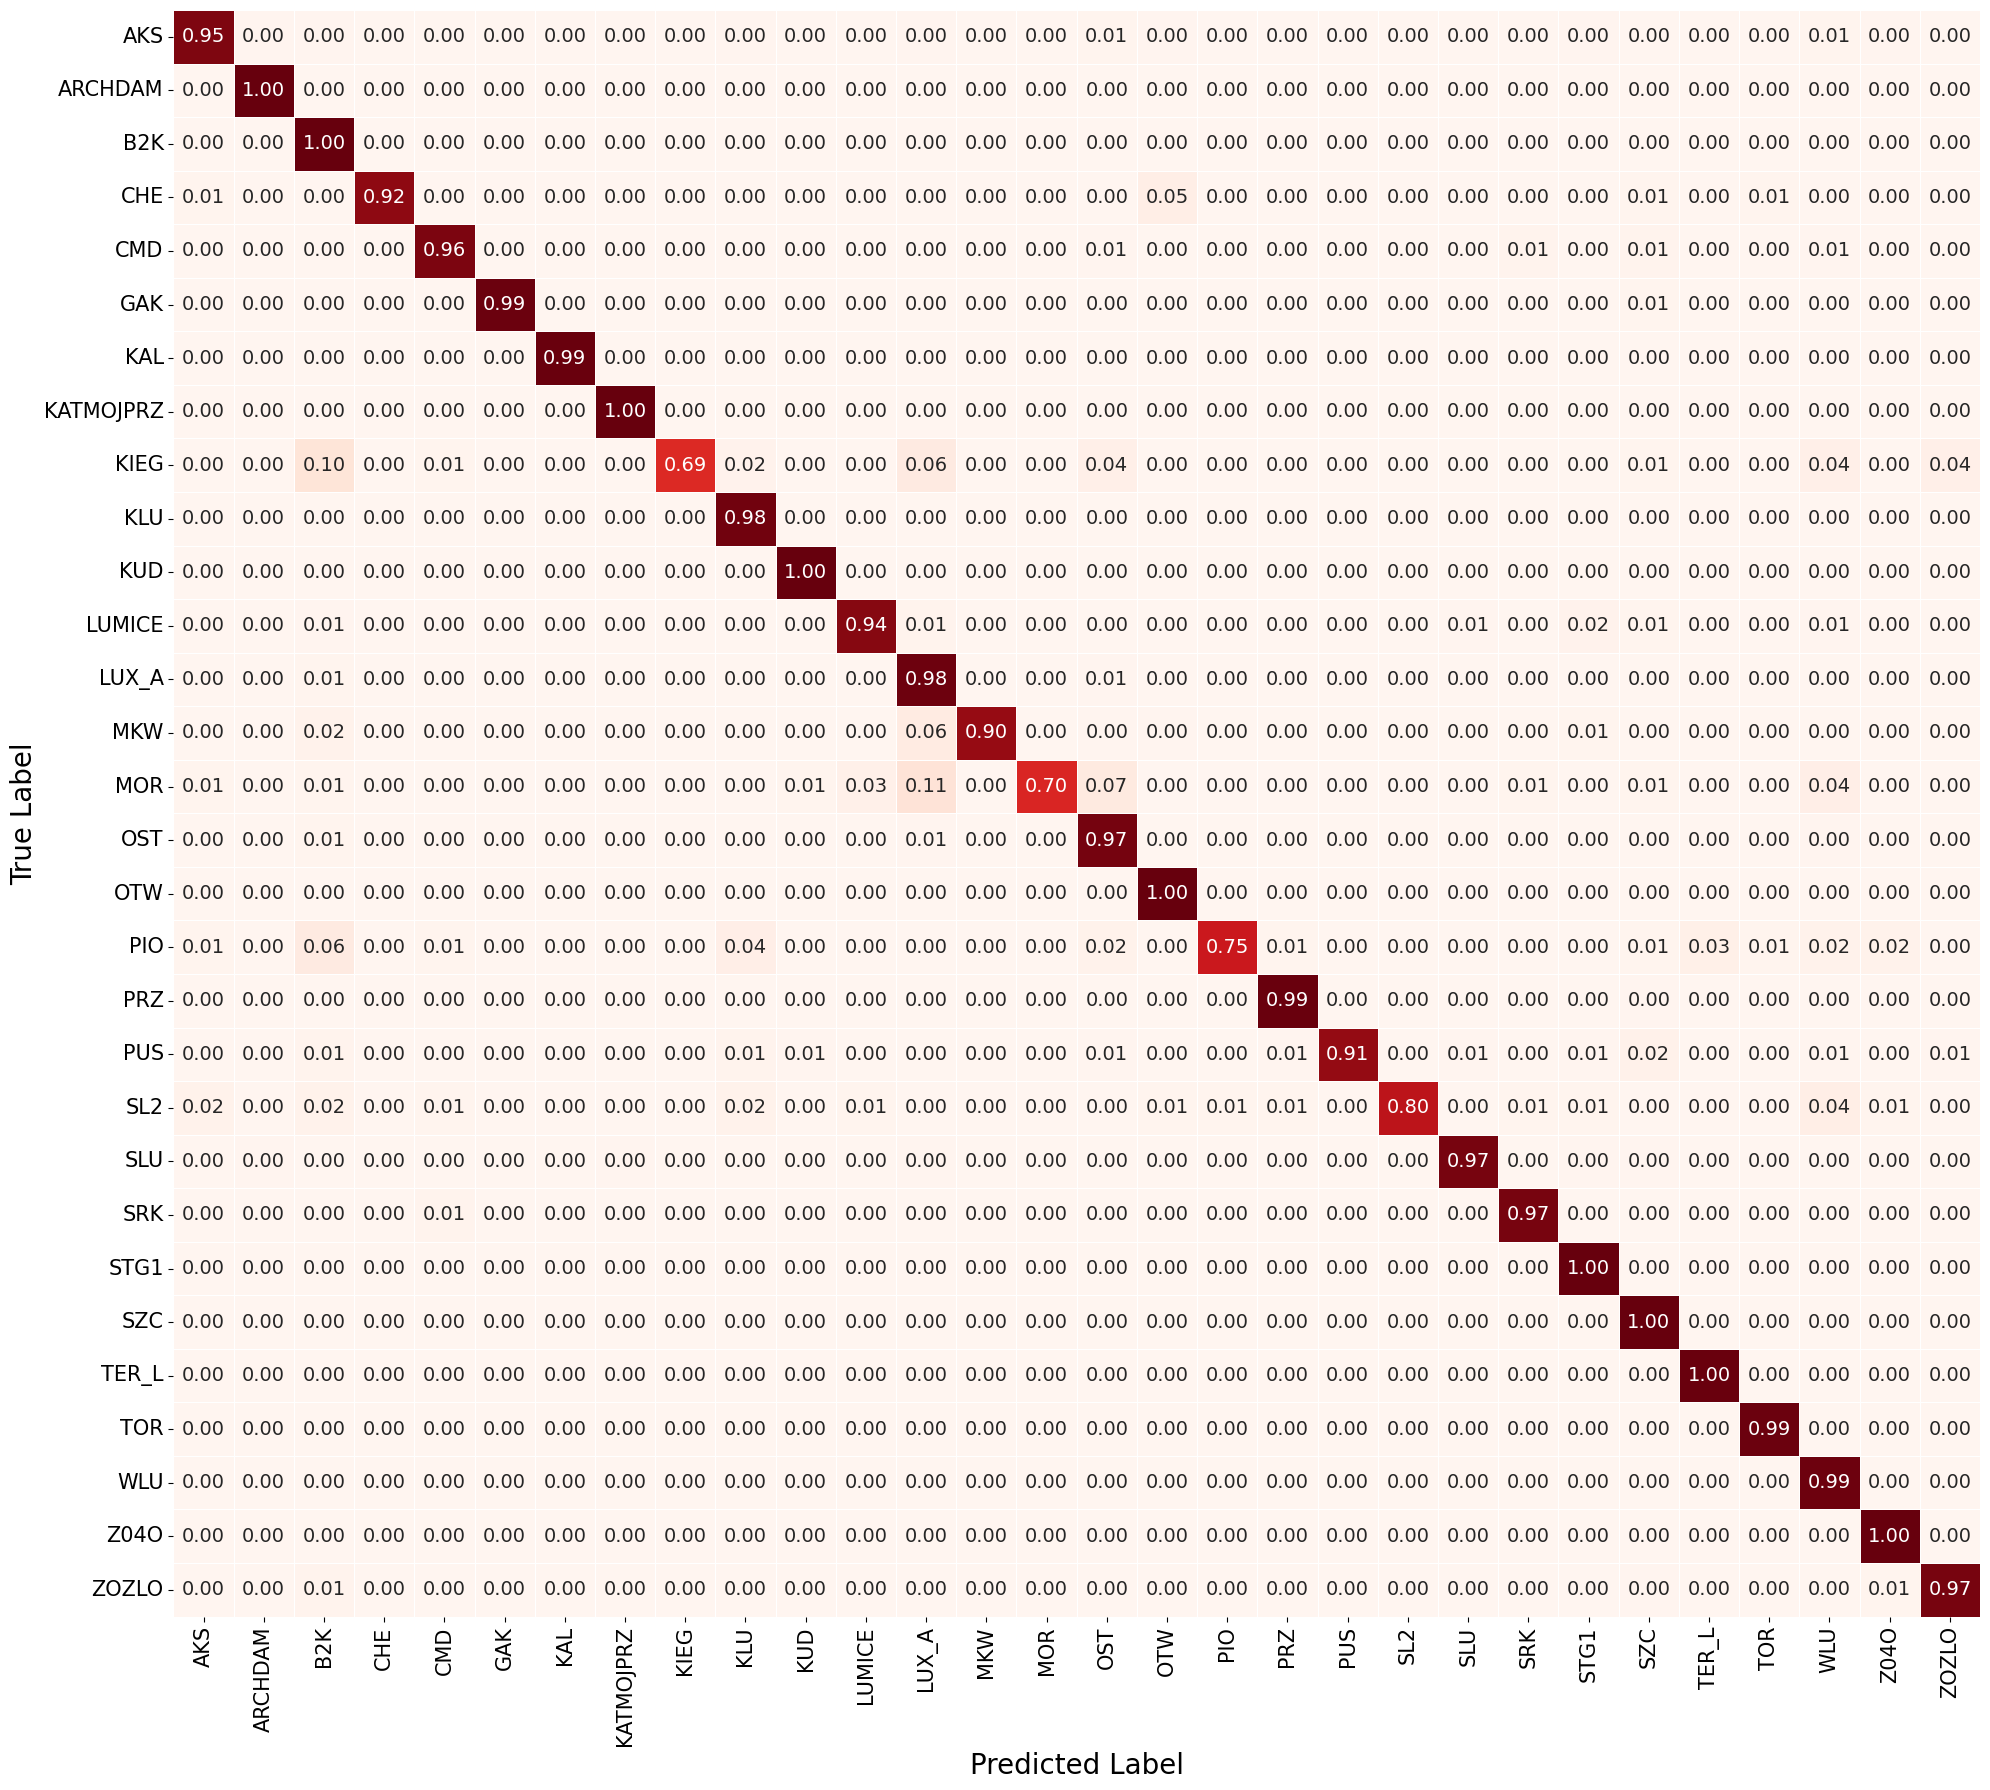

In [24]:
hospital_names = list(conf_matrices_data.values())[0]
conf_matrices = list(conf_matrices_data.values())[1:]
mean_conf_matrix = np.sum(conf_matrices, axis=0)
normalized_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)
plt.figure(figsize=(20, 18))
ax = sns.heatmap(
    normalized_conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    annot_kws={"size": 14},
    cbar=False
)
ax.set_xlabel("Predicted Label", fontsize=20)
ax.set_ylabel("True Label", fontsize=20)
#ax.set_title("Mean Normalized Confusion Matrix (across folds)")
plt.xticks(rotation=90)
ax.set_xticklabels(hospital_names, fontsize=15)
plt.yticks(rotation=0)
ax.set_yticklabels(hospital_names, fontsize=15)
plt.tight_layout()
#plt.savefig('results/figures/hospital_classification_avg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
X_original_df = df_feats.to_numpy()
sites_series = df_info['institution_id_encoded'].to_numpy()

combat = CombatModel()
X_harmonized_df = combat.fit_transform(X_original_df, sites_series, (df_info['patient_sex'] == 'Male').astype(int).to_numpy().reshape(-1, 1), df_info['age_dec'].to_numpy().reshape(-1, 1))

In [12]:
scaler = SiteWiseStandardScaler()
X_harmonized_df = scaler.fit_transform(df_feats.copy(), df_info['institution_id_encoded'])

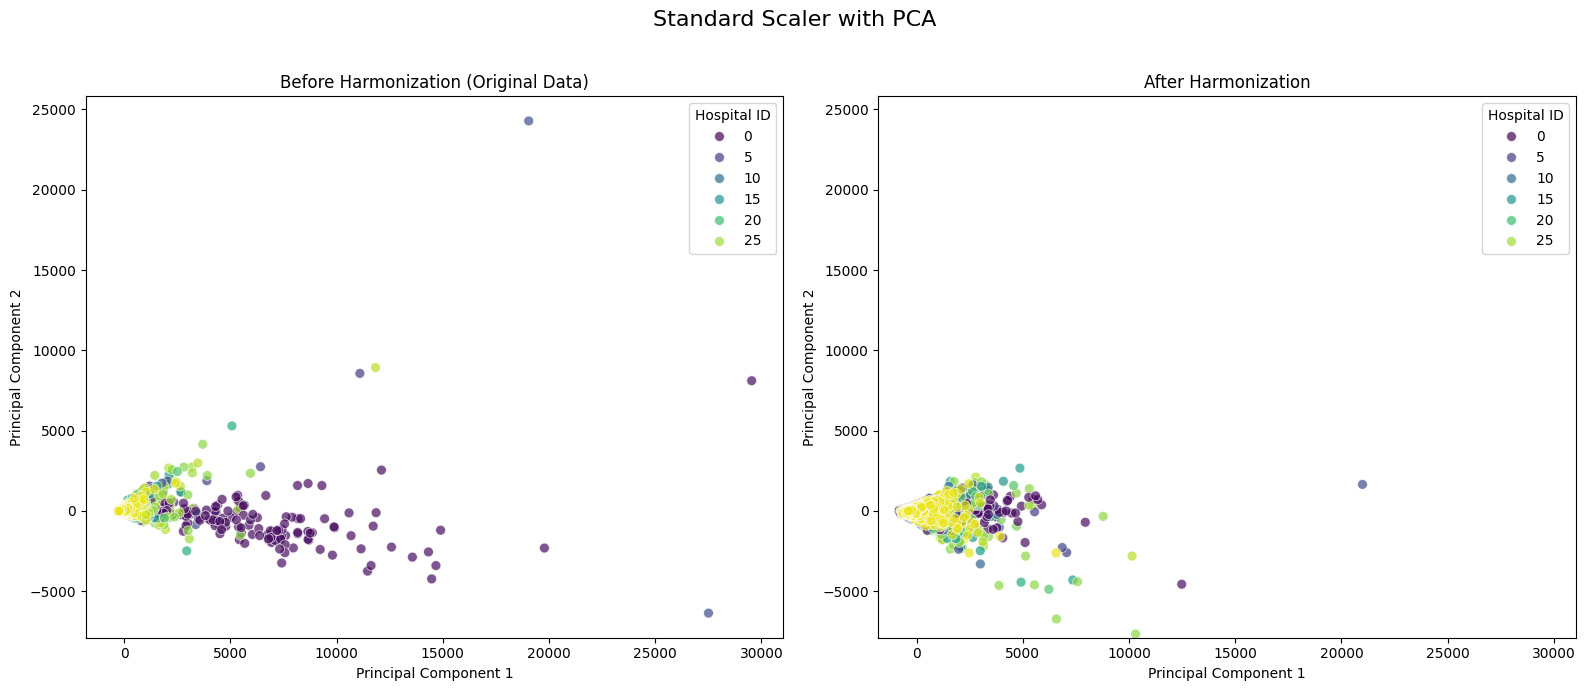

In [32]:
# PCA on original data
pca_orig = PCA(n_components=2)
X_pca_orig = pca_orig.fit_transform(X_original_df)
pca_orig_df = pd.DataFrame(data=X_pca_orig, columns=['PC1', 'PC2'])
pca_orig_df['Site'] = sites_series

# PCA on harmonized data
pca_harm = PCA(n_components=2)
X_pca_harm = pca_harm.fit_transform(X_harmonized_df)
pca_harm_df = pd.DataFrame(data=X_pca_harm, columns=['PC1', 'PC2'])
pca_harm_df['Site'] = sites_series

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Standard Scaler with PCA', fontsize=16)

sns.scatterplot(
    ax=axes[0],
    x='PC1', y='PC2',
    hue='Site',
    data=pca_orig_df,
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[0].set_title('Before Harmonization (Original Data)')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].legend(title='Hospital ID')

x_limits = axes[0].get_xlim()
y_limits = axes[0].get_ylim()

sns.scatterplot(
    ax=axes[1],
    x='PC1', y='PC2',
    hue='Site',
    data=pca_harm_df,
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[1].set_title('After Harmonization')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].legend(title='Hospital ID')

axes[1].set_xlim(x_limits)
axes[1].set_ylim(y_limits)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# UMAP

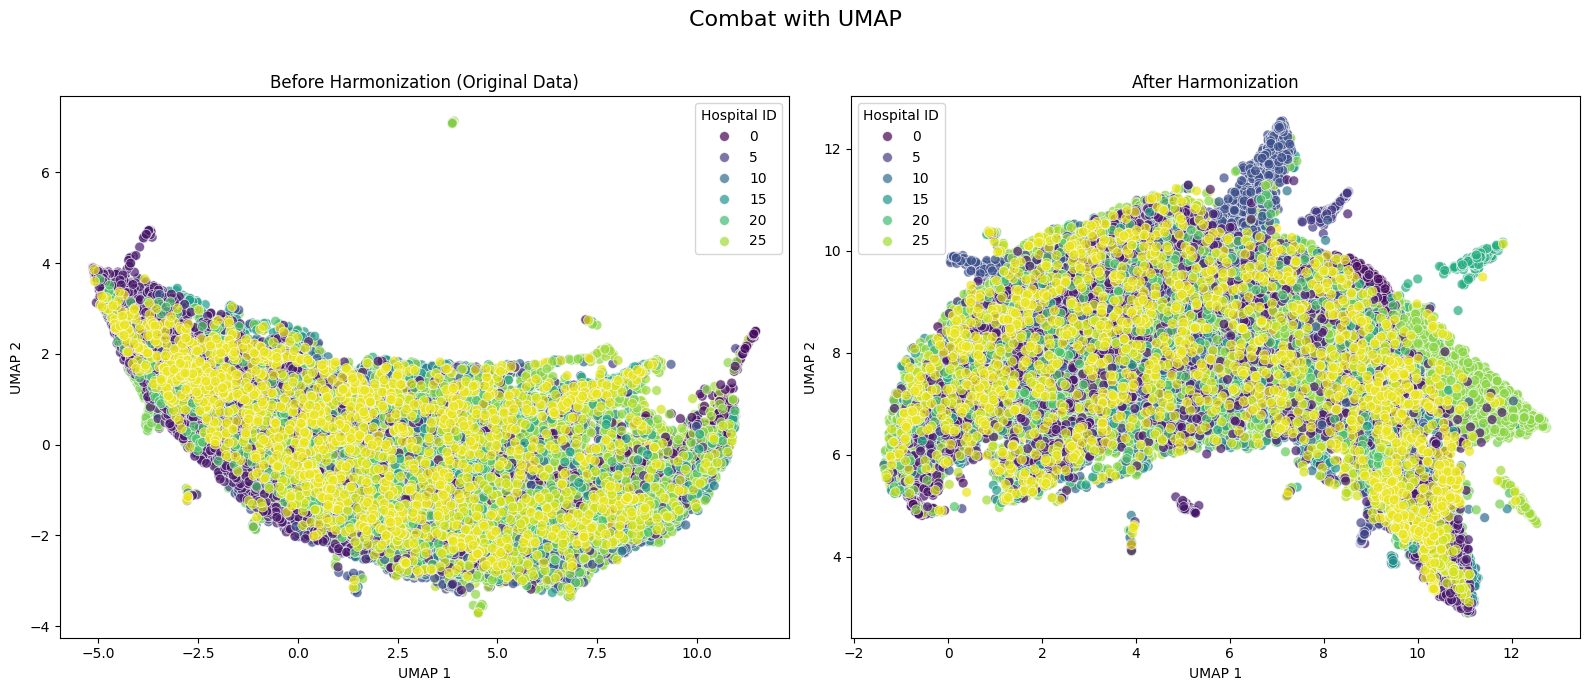

In [35]:
# UMAP on original data
umap_orig = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap_orig = umap_orig.fit_transform(X_original_df)
umap_orig_df = pd.DataFrame(data=X_umap_orig, columns=['UMAP1', 'UMAP2'])
umap_orig_df['Site'] = sites_series

# UMAP on harmonized data
umap_harm = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
X_umap_harm = umap_harm.fit_transform(X_harmonized_df)
umap_harm_df = pd.DataFrame(data=X_umap_harm, columns=['UMAP1', 'UMAP2'])
umap_harm_df['Site'] = sites_series

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Combat with UMAP', fontsize=16)

sns.scatterplot(
    ax=axes[0],
    x='UMAP1', y='UMAP2',
    hue='Site',
    data=umap_orig_df,
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[0].set_title('Before Harmonization (Original Data)')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].legend(title='Hospital ID')

sns.scatterplot(
    ax=axes[1],
    x='UMAP1', y='UMAP2',
    hue='Site',
    data=umap_harm_df,
    palette='viridis',
    s=50,
    alpha=0.7
)
axes[1].set_title('After Harmonization')
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].legend(title='Hospital ID')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# D-cohen

In [26]:
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    v1, v2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    denom = (n1 + n2 - 2)
    if denom == 0:
        return 0
    pooled = np.sqrt(((n1 - 1)*v1 + (n2 - 1)*v2) / denom)

    return 0 if pooled == 0 else (m1 - m2) / pooled

df_all = pd.concat([
    df_info.reset_index(drop=True), 
    pd.DataFrame(X_harmonized_df, columns=df_feats.columns).reset_index(drop=True)
], axis=1)

results = {}
for inst_id, group in df_all.groupby("institution_id"):
    rest = df_all.loc[df_all['institution_id'] != inst_id, df_feats.columns]
    d_scores = {feat: cohens_d(group[feat], rest[feat]) for feat in df_feats.columns}
    results[inst_id] = d_scores

df_cohens_d = pd.DataFrame(results).T


# results_ava = {}

# institutions = df_all['institution_id'].unique()
# for inst1 in enumerate(institutions):
#     print(i, len(institutions))
#     row_scores = {}
#     group1 = df_all[df_all['institution_id'] == inst1][df_feats.columns]
#     for inst2 in institutions:
#         group2 = df_all[df_all['institution_id'] == inst2][df_feats.columns]
#         d_vals = [cohens_d(group1[feat], group2[feat]) for feat in df_feats.columns]
#         row_scores[inst2] = np.mean(np.abs(d_vals))
#     results_ava[inst1] = row_scores

# df_cohens_d_ava = pd.DataFrame(results_ava)

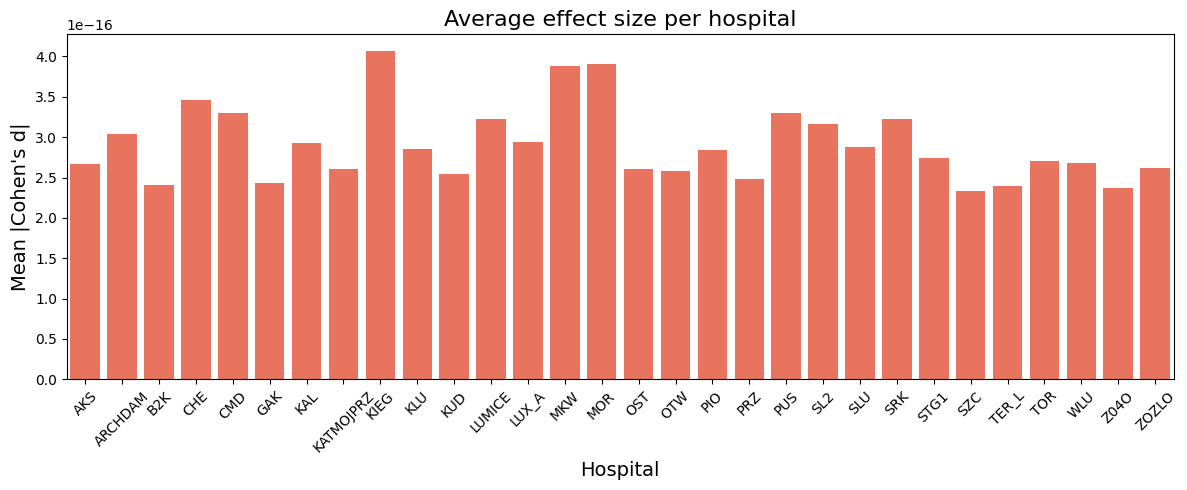

In [28]:
cohen_mean = df_cohens_d.abs().mean(axis=1)


plt.figure(figsize=(12, 5))
sns.barplot(x=cohen_mean.index, y=cohen_mean.values, color='tomato')
plt.ylabel("Mean |Cohen's d|", fontsize=14)
plt.xlabel("Hospital", fontsize=14)
plt.title("Average effect size per hospital", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
#plt.ylim(0,0.6)
plt.show()